# Метод статистической деконволюции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from random import random

In [2]:
from modules_reloader import reloader
from modules import randomized_ir, utils, plots, mcmc
relmod = reloader(randomized_ir, utils, plots, mcmc)

In [3]:
SAVE_IMAGES = False

## IR

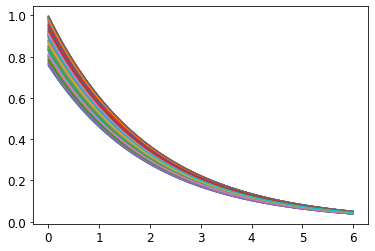

In [24]:
L_true = 5.99
pts_per_bin = 100

ir_x = np.linspace(0, L_true, int(L_true * pts_per_bin))

# exp-decay
gamma = 0.5
ir_y = np.exp(- gamma * ir_x)

# step
# step_width = 3
# step_start = 0
# ir_y = (np.logical_and(ir_x > step_start, ir_x <= step_start+step_width)).astype('float')

# gaussian shape
# x_max = 1
# x_sigma = 1
# ir_y = np.exp(- (ir_x - x_max) ** 2 / (2 * x_sigma ** 2))

factor_min, factor_max = 0.75, 1
rir = randomized_ir.RandomizedIr(ir_x, ir_y, factor=lambda n: factor_min + np.random.uniform(size=(n,))*(factor_max - factor_min))
# rir = randomized_ir.RandomizedIr(ir_x, ir_y)

rir.plot_realizations(count=100)

# Convoluted signal

Pic: `\ref{pic:problem-setup}`


In [25]:
N = 30
n_vec_mean = 15

n_vec = utils.generate_poissonian_ns(n_vec_mean, N)

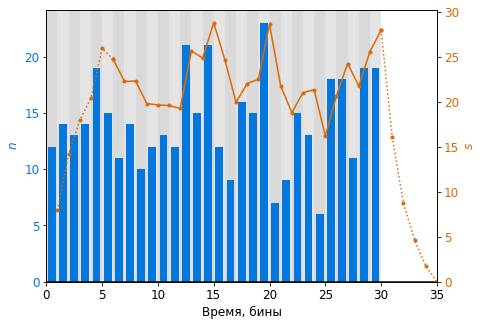

In [26]:
# uniform inbin time distribution:
s_vec = rir.convolve_with_n_vec(n_vec)

# non trivial inbin time distribution:
# S_vec = rir.convolve_with_n_vec(n_vec, inbin_invcdf=lambda x: x**(1/10), debug_inbin_times=True)

filename = 'problem-setup-example' if SAVE_IMAGES else None

f, a = plots.plot_convolution(n_vec, s_vec, filename=filename)

# Mean-based estimation

Chapter: `Грубая оценка методом наименьших квадратов`

In [29]:
rireff = randomized_ir.RandomizedIrEffect(rir, N, samplesize=100000)

L = rireff.L

In [30]:
rireff.explore()

L=5 and N=30
RIR effects from photon in the bin #1 (t in [0; 1]):
t	effect
1	0.69 +/- 0.11
2	0.42 +/- 0.07
3	0.25 +/- 0.04
4	0.15 +/- 0.03
5	0.09 +/- 0.02
6	0.06 +/- 0.01

C matrix used to calculate mean-vector for a given n vector (with cut edge effects):
[[0.05606744 0.09318492 0.15363597 0.25330289 0.41762586 0.68854864
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.05606744 0.09318492 0.15363597 0.25330289 0.41762586
  0.68854864 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.05606744 0.09318492 0.15363597 0.25330289
  0.41762586 0.68854864 0.         0.    

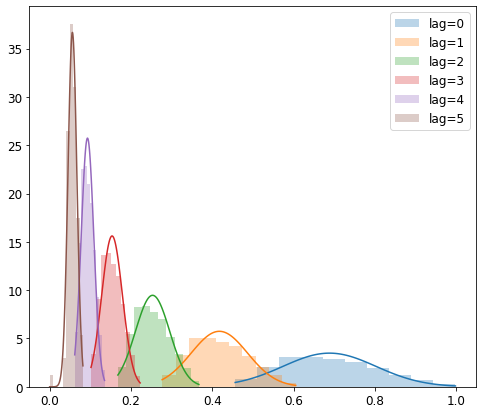

In [12]:
rireff.plot_samples()

In [13]:
n_vec_estimation = rireff.estimate_n_vec(s_vec)

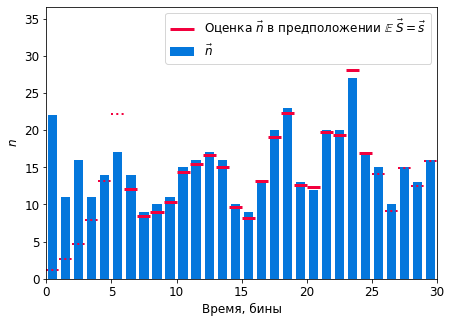

In [15]:
filename = 'mean-estimation' if SAVE_IMAGES else None
f, a = plots.plot_mean_n_estimation(n_vec, n_vec_estimation, L, filename=filename)

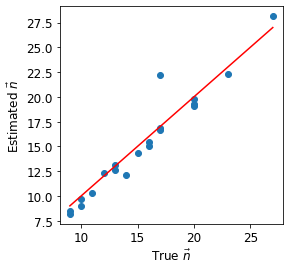

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))

cut_n_vec = n_vec[L:-L]
cut_n_vec_estimation = n_vec_estimation[L:-L]

ax.scatter(cut_n_vec, cut_n_vec_estimation)

n_minmax = np.linspace(cut_n_vec.min(), cut_n_vec.max(), 2)
ax.plot(n_minmax, n_minmax, 'r-')

ax.set_xlabel("True $\\vec{n}$")
ax.set_ylabel("Estimated $\\vec{n}$")

plt.show()

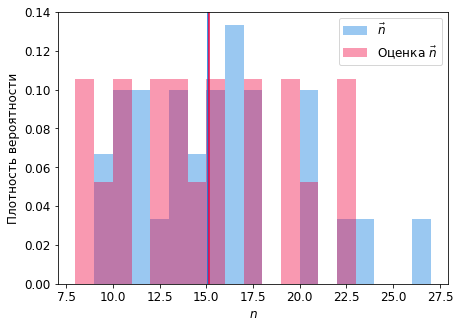

In [18]:
# filename = 'mean-estimation-assessment'
filename = None
f, a = plots.plot_mean_n_estimation_assessment(n_vec, n_vec_estimation, L, filename=filename)

# MCMC estimation

In [21]:
s_vec_error = np.ones_like(s_vec, dtype=float)

density = True

loglike = rireff.get_loglikelihood_mvn(s_vec, s_vec_error, debug_integration=False, density=density)

# loglike = rireff.get_loglikelihood_independent_normdist(s_vec, s_vec_error, density=density)
# loglike(n_vec_estimation)  # numba compilation

loglike_timing = utils.timer(lambda *a, **kw: '')(loglike)
loglike_timing(n_vec_estimation, mvn_params={'maxpts': 1000 * N})

loglikelihood_mvn() took 0.001 seconds to complete.


-2.03152773317834

In [52]:
n_vec_min = np.zeros_like(n_vec_estimation, dtype=float)
n_vec_max = n_vec_estimation * 100

def logposterior(n_vec):
    if np.any(np.logical_or(n_vec < n_vec_min, n_vec > n_vec_max)):
        return - np.inf
    return loglike(n_vec)

In [55]:
result = mcmc.run_mcmc(
    logposterior,
    n_vec_estimation,
    L,
    mcmc.SamplingConfig(
        progress_bar=True,
        n_samples=5000,
        n_walkers=128,
        debug_acceptance_fraction_each=None,
        autocorr_estimation_each=500,
        multiprocessing=True,
    )
)

100%|██████████| 5000/5000 [04:09<00:00, 20.05it/s]


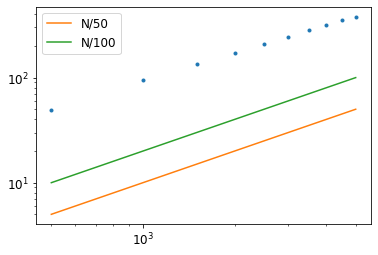

In [56]:
Ns, tau = result.N_tau

Ns = np.array(Ns)
tau = np.array(tau)

plt.plot(Ns, tau, '.')
plt.plot(Ns, Ns / 100, label='N/50')
plt.plot(Ns, Ns / 50, label='N/100')

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [91]:
relmod()

In [92]:
ind_sample = mcmc.extract_independent_sample(result.sampler, debug=True)

N/50 = 100;
tau: [589.65902265 555.12435898 471.12759988 355.13144846 362.52628728
 580.59858002 508.77975512 495.24340229 440.41285553 366.29565231
 367.71905861 392.21885973 357.97978266 337.1111049  359.19931526
 359.84445272 385.34957189 334.65058231 358.2035198  344.68179501
 357.55579876 362.22762243 339.50703427 364.99638854 348.86903488
 349.23533445 343.96846499 338.53932339 360.51226581 355.40780584]
Autocorrelation time is estimated at 394.7558692926762 (ranges from 334.6505823144324 to 589.6590226507906)
Burn-in = 1179 samples
Thinning = 301 samples


In [93]:
ind_sample.shape

(1536, 30)

/home/njvh/Documents/Science/sphere/thesis/modules/plots.py:215: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/home/njvh/Documents/Science/sphere/thesis/modules/plots.py:215: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  


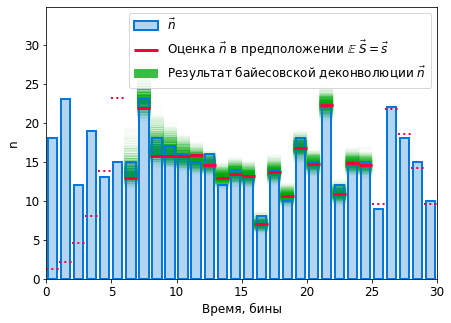

In [94]:
filename = 'bayesian-estimation-result' if SAVE_IMAGES else None
f, a = plots.plot_bayesian_mean_estimation(n_vec, ind_sample, L, n_vec_estimation, filename=filename)

Text(0.5, 0, 'n')

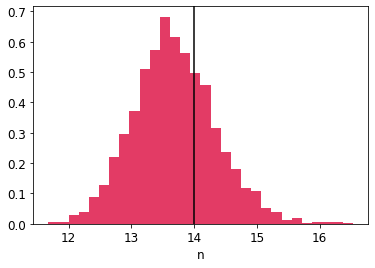

In [78]:
fig, ax =  plt.subplots()

ibin = 17

ax.hist(ind_sample[:, ibin], bins=30, density=True, color='#e33b65')
ax.axvline(n_vec[ibin], color='black')

ax.set_xlabel('n')